# inspect MARC simulations

- MARS 2D 250 1/4h, 2006-2024: `/home/ref-oc-public/modeles_marc/f1_e2500/best_estimate/`

- Mars Agrif 3D 500m 1h, 2010-2019: `/home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-FINIS/best_estimate/`

- Mars 3D 2500m 1h, 2006-2024: `/home/ref-oc-public/modeles_marc/l1_v9/MARC_L1-MARS2D-FINIS250/best_estimate`


https://github.com/apatlpo/taos/blob/main/taos/mars.py

In [1]:
import os
from glob import glob
import threading

import xarray as xr
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import cmocean.cm as cm
import gsw

from xgcm import Grid
import pynsitu as pyn

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
path_2d = "/home/ref-oc-public/modeles_marc/f1_e2500/best_estimate/"
path_3d_500m = "/home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-FINIS/best_estimate/"
path_3d_250m = "/home/ref-oc-public/modeles_marc/l1_v9/MARC_L1-MARS2D-FINIS250/best_estimate"  

In [3]:
lonc, latc = -5, 48
zooms = dict(
    large=[-10,0,45,50],
    iroise=[-5.8, -4.5, 47.7, 48.8],
    ouessant=[-5.3, -4.95, 48.3, 48.55],
)

def browse_files(dataset, year=None, daily=False, filtre=False):
    """Browse simulation directory and figure out output files"""
    if dataset=="2d":
        root_dir = path_2d
    elif dataset=="3d_500m":
        root_dir = path_3d_500m
    elif dataset=="3d_250m":
        root_dir = path_3d_250m
    
    #suff = "MARC_F1-"
    suff = "MARC_"
    if year is not None:
        dpath = os.path.join(root_dir, str(year), suff + "*.nc")
    else:
        dpath = os.path.join(root_dir, "*/" + suff + "*.nc")
    files = sorted(glob(dpath))

    # exclude some files
    if not filtre:
        files = [f for f in files if "FILTRE" not in f]

    dates = [extract_date(f, daily) for f in files]
       
    df = pd.DataFrame({"files": files}, index=dates)
    # get rid of bad times
    df = df.loc[~pd.isna(df.index)]
    
    return df

def extract_date(f, daily):
    """extract date from file name"""
    if "MeteoMF" in f:
        f = f.replace("_MeteoMF", "")
    if daily:
        # MARC_F1-MARS3D-SEINE_20100702T1200Z_FILTRE.nc
        _date = f.split("/")[-1].split("_")[-2].replace(".nc", "")
    else:
        _date = f.split("/")[-1].split("_")[-1].replace(".nc", "")
    try:
        return pd.Timestamp(_date)
    except:
        #print(_date, f)
        return None

def read_one_file(f, i=None, j=None, z=True, eos=True, drop=True, chunks={"level": 1}):
    """Read one netcdf mars file

    Parameters
    ----------
    f: str
        path to netcdf file
    i, j: int
        index for slicing along i or j directions
    z: boolean, True by default
        add depth coordinate
    eos: boolean, True by default
        add equations of station variables
    drop; boolean, True by default
        drops variables that are not in all netcdf files
    """

    ds = xr.open_dataset(f, chunks=chunks)
    ds = _rename_dims(ds)

    if i is not None:
        ds = ds.isel(ni=i)
    if j is not None:
        ds = ds.isel(nj=j)

    flag_z = (z and ds.level.size>1)
    if flag_z:
        ds = ds.assign_coords(z=get_z(ds))

    ds = ds.transpose("time", "level", "nj", "nj_v", "ni", "ni_u")
            
    if eos and flag_z:
        ds = add_eos(ds)

    if drop is True or isinstance(drop, list):
        drop_vars = ["adapt_imp_ts", "adapt_imp_uz", "adapt_imp_vz"]
        if isinstance(drop, list):
            drop_vars = drop
        ds = ds.drop_vars(drop_vars, errors="ignore")

    return ds

def _rename_dims(ds):
    """Some dimensions are not necessary and may complicate the use of xgcm"""
    ds = ds.copy()
    for v in ds.reset_coords():
        if "ni_v" in ds[v].dims:
            ds[v] = ds[v].rename(ni_v="ni")
        if "nj_u" in ds[v].dims:
            ds[v] = ds[v].rename(nj_u="nj")
        if "ni_f" in ds[v].dims:
            ds[v] = ds[v].rename(ni_f="ni_u")
        if "nj_f" in ds[v].dims:
            ds[v] = ds[v].rename(nj_f="nj_v")
    ds = ds.drop_dims(["ni_v", "nj_u", "ni_f", "nj_f"])
    return ds


def get_z(ds, s=None):
    # z(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) + (depth(j,i)-depth_c)*C(k)
    if s is None:
        s = ds.SIG
    eta, depth, depth_c, C = ds.XE, ds.H0, ds.hc, ds.Csu_sig
    # fill land values with 0
    eta = eta.fillna(0.0)
    depth = depth.fillna(1.0)
    depth_c = depth_c.fillna(0.0)
    return eta * (1 + s) + depth_c * s + (depth - depth_c) * C


def get_horizontal_indices(ds, lon=-0.6, lat=49.7):
    """returns grid index of a position

    Parameters
    ----------
    ds: xr.Dataset
        dataset containing grid information ("longitude", "longitude_u", ...)
    lon, lat: float, optional
        Coordinate of the point of interest, default: lon=-.6, lat=49.7
    """
    coords = {}
    for v, suffix in zip(["rho", "u", "v"], ["", "_u", "_v"]):
        dl2 = (ds["longitude" + suffix] - lon) ** 2 * np.sin(
            np.pi / 180.0 * lat
        ) ** 2 + (ds["latitude" + suffix] - lat) ** 2
        _min = dl2.where(dl2 == dl2.min(), drop=True)
        coords[v] = {c: _min[c].values[0] for c in _min.dims}
    coords["position"] = (lon, lat)
    return coords


def get_xgrid(ds):
    """Create xgcm grid object"""
    coords = {
        "x": {"center": "ni", "left": "ni_u"},
        "y": {"center": "nj", "left": "nj_v"},
    }
    if "level" in ds.dims and "level_w" in ds.dims:
        coords["s"] = {"center": "level", "outer": "level_w"}
    xgrid = Grid(ds, periodic=False, coords=coords, boundary="extend", autoparse_metadata=False)
    return xgrid


def get_ij_dims(da):
    i = next((d for d in da.dims if "ni" in d))
    j = next((d for d in da.dims if "nj" in d))
    return i, j


def get_grid_angle(lon, lat):
    """get grid orientation"""
    # lon, lat = ds.longitude, ds.latitude
    sc = np.cos(np.pi / 180 * lat)
    tan = (lat.shift(ni=-1) - lat) / (lon.shift(ni=-1) - lon) / sc
    phi = np.arctan(tan)
    return phi


def rotate(u, v, phi):
    _u = np.cos(phi) * u - np.sin(phi) * v
    _v = np.sin(phi) * u + np.cos(phi) * v
    return _u, _v


# -----------------------------


def add_eos(ds, S="SAL", PT="TEMP"):
    assert "z" in ds, "You must first add the vertical coordinate z with get_z"
    lon, lat = 0, 49.5
    ds["SA"] = (ds[S].dims, gsw.SA_from_SP(ds[S].data, -ds.z.data, lon, lat))
    ds["CT"] = (ds[S].dims, gsw.CT_from_pt(ds[S].data, ds[PT].data))
    ds["sigma0"] = (ds[S].dims, gsw.sigma0(ds[S].data, ds[PT].data))
    return ds


def TS_plot(ds, t_range=None, s_range=None, figsize=(5, 5)):

    if t_range is None:
        t_range = (ds.TEMP.min().values, ds.TEMP.max())
    if s_range is None:
        s_range = (ds.SAL.min().values, ds.SAL.max())

    nt, ns = 100, 100
    _ds = xr.Dataset(
        coords=dict(
            theta=(("theta",), np.linspace(t_range[0], t_range[1], num=nt)),
            salinity=(("salinity",), np.linspace(s_range[0], s_range[1], num=ns)),
        )
    )
    _ds["salinity2"], _ds["theta2"] = xr.broadcast(_ds["salinity"], _ds["theta"])
    _ds["z"] = 0.0 * _ds["salinity2"]
    _ds = add_eos(_ds, S="salinity2", PT="theta2")

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    CS = _ds.sigma0.plot.contour(
        y="theta", x="salinity", ax=ax, levels=20, add_labels=True, cmap=cm.dense
    )
    ax.clabel(CS, inline=1, fontsize=10)
    ax.grid()

    return fig, ax


def potential_energy_anomaly(ds):
    # a bit inaccurate numerically
    g = 9.81
    h = (ds.sigma0 * 0 + 1).integrate("level")
    rho_bar = (ds.sigma0).integrate("level") / h
    Ep = (g * (ds.sigma0 - rho_bar) * ds.z).integrate("level") / h
    return Ep.rename("phi")


# -----------------------------


def get_cmap_colors(Nc, cmap="plasma"):
    """load colors from a colormap to plot lines

    Parameters
    ----------
    Nc: int
        Number of colors to select
    cmap: str, optional
        Colormap to pick color from (default: 'plasma')
    """
    scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc), cmap=cmap)
    return [scalarMap.to_rgba(i) for i in range(Nc)]


def plot_iroise(
    da,
    uv=None,
    stream=None,
    zoom=None,
    title=None,
    fig=None,
    ax=None,
    contours=False,
    colorbar=True,
    colorbar_kwargs={},
    center_colormap=False,
    gridlines=True,
    dticks=(1, 1),
    land=True,
    coast_resolution="10m",
    offline=False,
    figsize=0,
    savefig=None,
    xy=("longitude", "latitude"),
    **kwargs,
):
    
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:

        if offline:
            plt.switch_backend("agg")

        if figsize == 0:
            _figsize = (10, 5)
        elif figsize == 1:
            _figsize = (20, 10)
        else:
            _figsize = figsize
        if fig is None and ax is None:
            fig = plt.figure(figsize=_figsize)
            ax = fig.add_subplot(111, projection=ccrs.Orthographic(lonc, latc))

        if center_colormap:
            vmax = float(abs(da).max())
            vmin = -vmax
            kwargs["vmin"] = vmin
            kwargs["vmax"] = vmax

        if contours:
            im = da.squeeze().plot.contourf(
                x=xy[0],
                y=xy[1],
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=False,
                **kwargs,
            )            
        elif da is not None:
            im = da.squeeze().plot.pcolormesh(
                x=xy[0],
                y=xy[1],
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=False,
                **kwargs,
            )

        if uv is not None:
            dij = uv[1]
            u, v = uv[0]
            #u = uv[0].u
            #v = uv[0].v
            u = u.isel(ni=slice(0, None, dij), nj=slice(0, None, dij))
            v = v.isel(ni=slice(0, None, dij), nj=slice(0, None, dij))
            #u_src_crs = u / np.cos(u.latitude / 180 * np.pi)
            #v_src_crs = v
            #magnitude = np.sqrt(u**2 + v**2)
            #magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
            _kwargs = dict(transform=ccrs.PlateCarree(), units="width", scale=5)
            if len(uv) > 2:
                _kwargs.update(**uv[2])
            Q = ax.quiver(
                u.longitude.values,
                u.latitude.values,
                u.values,
                v.values,
                #(u_src_crs * magnitude / magn_src_crs).values,
                #(v_src_crs * magnitude / magn_src_crs).values,
                **_kwargs,
            )
            # for reference arrow, should use:
            # https://matplotlib.org/stable/gallery/images_contours_and_fields/quiver_demo.html
            if len(uv) > 3:
                uv_ref, x_ref, y_ref = uv[3]
            else:
                uv_ref, x_ref, y_ref = 1., .8, .9
            qk = ax.quiverkey(
                Q,
                x_ref, y_ref,
                #-4.6, 48.45,
                uv_ref,
                r"{:.2f} m/s".format(uv_ref),
                labelpos="E",
                coordinates="figure",
                #coordinates="data",
                #transform=ccrs.PlateCarree(),
                zorder=200,
            )
        if stream is not None:
            if len(stream)==2:
                u, v = stream
            else:
                u, v, skwargs = stream
            magnitude = np.sqrt(u**2+v**2)
            dskwargs = dict(transform=ccrs.PlateCarree(), linewidth=2, density=2, color=magnitude.values)
            dskwargs.update(**skwargs)
            ax.streamplot(u.longitude.values, v.latitude.values, u.values, v.values, **dskwargs)

        if zoom is None:
            _extent = ax.get_extent()
            set_extent = False            
        elif isinstance(zoom, str):
            _extent = zooms[zoom]
            set_extent = True
        elif isinstance(zoom, list):
            _extent = zoom
            set_extent = True

        # coastlines and land:
        if land:
            if isinstance(land, dict):
                # land = dict(args=['physical', 'land', '10m'],
                #            kwargs= dict(edgecolor='face', facecolor=cfeature.COLORS['land']),
                #           )
                land_feature = cfeature.NaturalEarthFeature(
                    *land["args"],
                    **land["kwargs"],
                )
            else:
                land_feature = cfeature.LAND
            ax.add_feature(land_feature, zorder=10)
        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color="k")

        if set_extent:
            ax.set_extent(_extent)

        if colorbar:
            # cbar = fig.colorbar(im, extend="neither", shrink=0.7, **colorbar_kwargs)
            axins = inset_axes(
                ax,
                width="5%",  # width = 5% of parent_bbox width
                height="100%",  # height : 50%
                loc="lower left",
                bbox_to_anchor=(1.05, 0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
            )
            # cbar = fig.colorbar(im, extend="neither", shrink=0.9,
            cbar = fig.colorbar(im, extend="neither", cax=axins, **colorbar_kwargs)
        else:
            cbar = None

        if gridlines:
            gl = ax.gridlines(
                draw_labels=True,
                dms=False,
                x_inline=False,
                y_inline=False,
            )
            gl.right_labels = False
            gl.top_labels = False

        if title is not None:
            ax.set_title(
                title,
                fontdict={
                    "fontsize": 12,
                },
            )  # "fontweight": "bold"
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150, bbox_inches="tight")
            plt.close(fig)
        #
        return fig, ax, cbar


def prepare_uv(u, v, ds, xgrid, dij=5, **kwargs):
    """prepare uv for quiver plot in plot_bs"""
    # interpolate at the cell center
    uv = (
        xr.merge(
            [
                xgrid.interp(u, "x").rename("u"),
                xgrid.interp(v, "y").rename("v"),
            ]
        ).assign_coords(longitude=ds.longitude, latitude=ds.latitude),
        dij,
        kwargs,
    )
    return uv


def plot_section(
    da,
    x,
    title=None,
    fig=None,
    ax=None,
    colorbar=True,
    colorbar_kwargs={},
    center_colormap=False,
    xlabel=True,
    ylabel=True,
    gridlines=True,
    offline=False,
    figsize=(10, 4),
    savefig=None,
    **kwargs,
):
    """Plot a vertical section"""

    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:

        if offline:
            plt.switch_backend("agg")

        if fig is None and ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
            # ax.set_facecolor("slategray")
            ax.set_facecolor("0.9")

        if center_colormap:
            vmax = float(abs(da).max())
            vmin = -vmax
            kwargs["vmin"] = vmin
            kwargs["vmax"] = vmax

        im = ax.pcolormesh(
            da.level * 0.0 + da[x],
            da.z,
            da,
            shading="gouraud",
            **kwargs,
        )

        ax.invert_xaxis()
        ax.set_ylim(top=0.0)
        if not ylabel:
            ax.set_yticklabels([])
        if not xlabel:
            ax.set_xticklabels([])

        if colorbar:
            axins = inset_axes(
                ax,
                width="5%",  # width = 5% of parent_bbox width
                height="100%",  # height : 50%
                loc="lower left",
                bbox_to_anchor=(1.05, 0.0, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
            )
            # cbar = fig.colorbar(im, extend="neither", shrink=0.9,
            cbar = fig.colorbar(im, extend="neither", cax=axins, **colorbar_kwargs)
        else:
            cbar = None
        if gridlines:
            ax.grid()

        if title is not None:
            ax.set_title(
                title,
                fontdict={
                    "fontsize": 12,
                },
            )  # "fontweight": "bold"
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)  # bbox_inches = "tight"
            plt.close(fig)
        #
        return fig, ax, cbar

In [4]:
files_2d = browse_files("2d", year="2018", daily=False)
files_3d_500 = browse_files("3d_500m", year="2018", daily=False)
files_3d_250 = browse_files("3d_250m", year="2018", daily=False)

print("Number of data files = {} ".format(len(files_2d)))

Number of data files = 8760 


---

## inspection a snapshot

In [5]:
# local wrapper
def _read_one_file(f):

    ds = read_one_file(f)
    
    # fill in coordinate variables
    for d in ["u", "v"]:
        for v in ["longitude", "latitude"]:
            if d=="u":
                dim="ni_u"
            else:
                dim="ni"
            ds[v+"_"+d] = ds[v+"_"+d].interpolate_na(dim=dim, method="linear", fill_value="extrapolate")
    
    xgrd = get_xgrid(ds)
    if "U" in ds:
        ds["u"] = xgrd.interp(ds.U, "x")
        ds["v"] = xgrd.interp(ds.V, "y")
    elif "UZ" in ds:
        ds["u"] = xgrd.interp(ds.UZ, "x")
        ds["v"] = xgrd.interp(ds.VZ, "y")

    return ds

In [6]:
#f = files_2d.loc["2018-01-01":"2018-01-30", "files"].iloc[1]
#f = files_3d_500.loc["2018-01-01":"2018-01-30", "files"].iloc[1]
f = files_3d_250.loc["2018-01-01":"2018-01-30", "files"].iloc[1]
print(f)

ds = _read_one_file(f)

/home/ref-oc-public/modeles_marc/l1_v9/MARC_L1-MARS2D-FINIS250/best_estimate/2018/MARC_L1-MARS2D-FINIS250_20180101T0015Z_MeteoMF.nc


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [7]:
# compute grid size resolution in meters
dx = float(ds.latitude.diff("nj").compute().mean())*111e3
print(f"Grid size = {dx:.0f}m")

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


Grid size = 250m


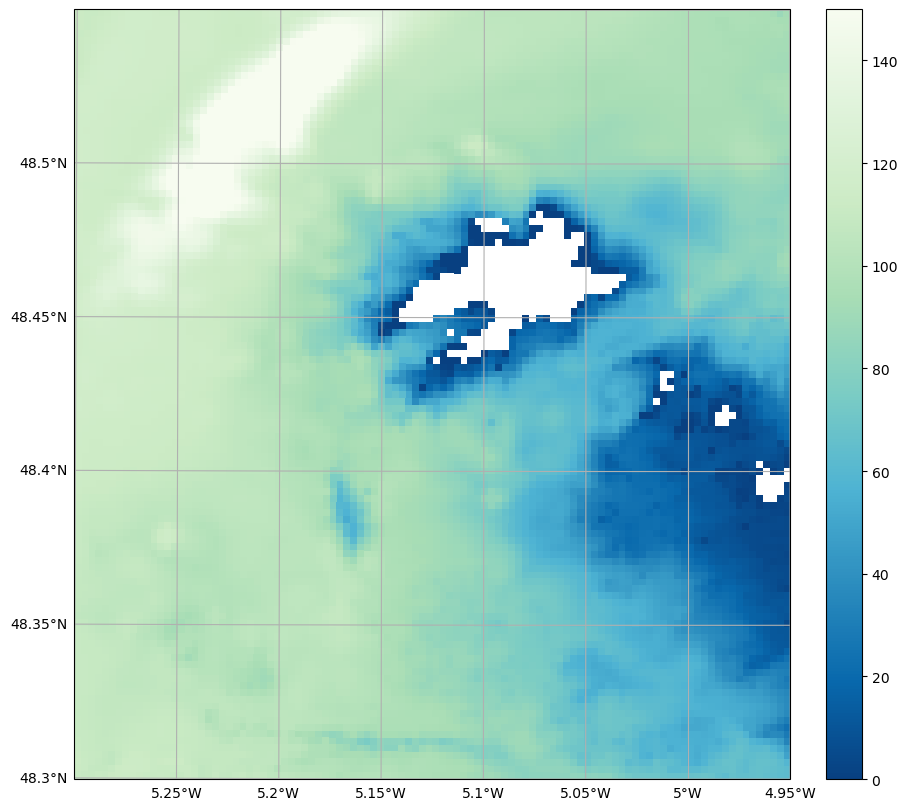

In [8]:
mkwargs = dict(
    #zoom = "large" # [-7.5, -3, 47., 49.5],
    #zoom = "iroise" # [-5.8, -4.5, 47.7, 48.8],
    zoom = [-5.3, -4.95, 48.3, 48.55],
    figsize=(10,10),
    #land = dict(args=['physical', 'land', '10m']),
    land = None,
    coast_resolution = None,
)

#fig, ax, cbar = plot_iroise(ds.UZ.isel(level=-1), xy=("longitude_u", "latitude_u"), zoom=zoom)
fig, ax, cbar = plot_iroise(
    ds.H0, vmin=0, vmax=150, cmap="GnBu_r",
    **mkwargs,
)


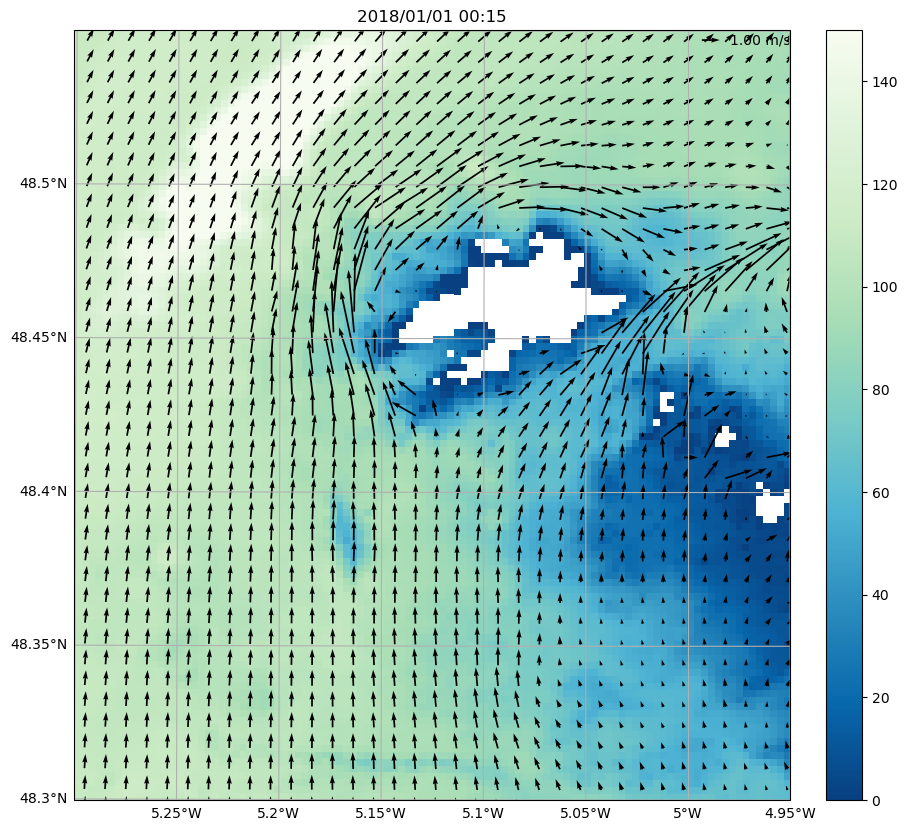

In [11]:
if "level" in ds.u.dims:
    u, v = ds.u.isel(level=0, time=0), ds.v.isel(level=0, time=0)
else:
    u, v = ds.u.isel(time=0), ds.v.isel(time=0)

fig, ax, cbar = plot_iroise(
    ds.H0, vmin=0, vmax=150, cmap="GnBu_r",
    #uv=((ds.u.isel(level=0, time=0), ds.v.isel(level=0, time=0)), 1, dict(scale=10)),
    #uv=((ds.u.isel(level=0, time=0), ds.v.isel(level=0, time=0)), 5, dict(scale=20), (1.,.8,.9)), # iroise
    #uv=((u, v), 1, dict(scale=40), (1.,.8,.87)), # ouessant
    uv=((u, v), 3, dict(scale=40), (1.,.8,.87)), # ouessant
    title=ds.time.dt.strftime("%Y/%m/%d %H:%M").values[0],
    **mkwargs,
)

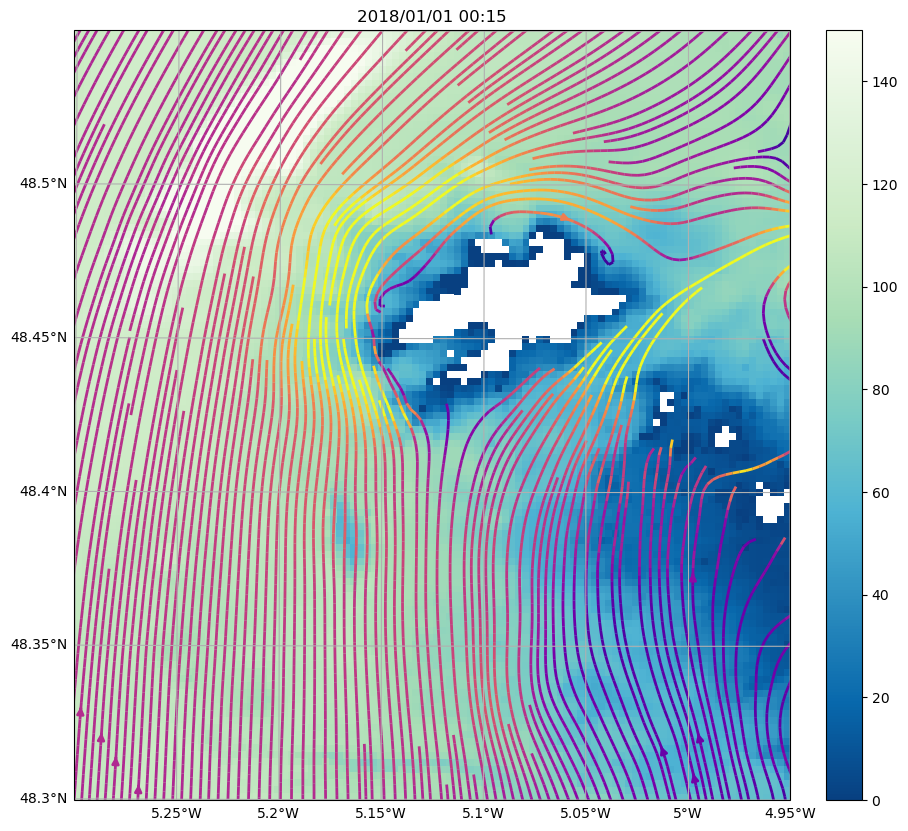

In [15]:
# slow
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=2)

fig, ax, cbar = plot_iroise(
    ds.H0, vmin=0, vmax=150, cmap="GnBu_r",
    stream=(u, v, dict(cmap="plasma", density=20, norm=norm)),
    title=ds.time.dt.strftime("%Y/%m/%d %H:%M").values[0],
    **mkwargs,
)

---
## station time series

In [16]:
stations = {}
stations["south"] = (-5.15, 48.35)
stations["bank"] = (-5.165, 48.385)
stations["bank west"] = (-5.2, 48.385)
stations["bank east"] = (-5.13, 48.385)
stations["north"] = (-5.18, 48.42)

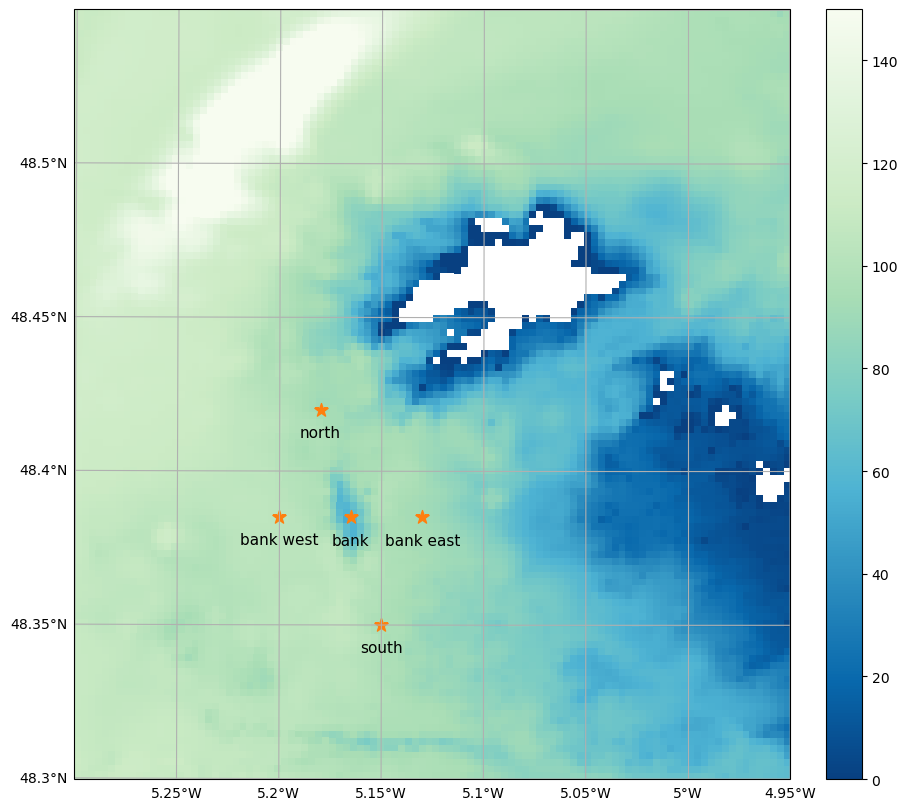

In [17]:
fig, ax, cbar = plot_iroise(
    ds.H0, vmin=0, vmax=150, cmap="GnBu_r",
    **mkwargs,
)

for s, p in stations.items():
    ax.scatter(p[0], p[1], s=100, c="C1", marker="*", transform=ccrs.PlateCarree())
    ax.text(p[0], p[1]-.005, s, size=11, transform=ccrs.PlateCarree(), va="top", ha="center")

In [18]:
def load_stations(stations, files):

    idx = {}

    time_range = pd.date_range(start="2018-01-01", end="2018-01-15", freq="1h")
    #time_range = pd.date_range(start="2018-01-01", end="2018-01-2", freq="12h")
    
    D = []
    for t in time_range:
        f = files.loc[str(t), "files"]

        ds = _read_one_file(f)

        if not idx:
            # find nearest position
            for s, p in stations.items():
                dl = ((ds.longitude-p[0])**2 + (ds.latitude-p[1])**2).compute()
                d = dl.argmin(["ni", "nj"])
                d["ni_u"] = d["ni"]
                d["nj_v"] = d["nj"]
                idx[s] = d

        D.append(
            xr.concat([ds.isel(**i).compute() for s, i in idx.items()], pd.Index(idx, name="station"))
        )

    return xr.concat(D, "time")

In [19]:
station_compute = False
#station_compute = False

#simulation = "2d"
simulation = "3d_250"
#simulation = "3d_500"

if simulation=="2d":
    _files = files_2d
elif simulation=="3d_250": # done
    _files = files_3d_250
elif simulation=="3d_500":
    _files = files_3d_500

station_file = f"/home/datawork-lops-osi/aponte/morpho/stations_{simulation}.nc"
if station_compute:
    st = load_stations(stations, _files)
    st.to_netcdf(station_file, mode="w")
else:
    st = xr.open_dataset(station_file)

In [20]:
S = dict(
    bank=dict(color="k"),
    south=dict(color="C0"),
    north=dict(color="C1"),
)

def plot_tseries(st):

    fig, axes = plt.subplots(3,1, figsize=(7,10), sharex=True)
    
    ax = axes[0]
    for s, k in S.items():
        st.sel(station=s).XE.plot(**k, ax=ax, label=s)
    ax.set_title("")
    ax.grid()
    ax.legend()
    ax.set_xlabel("")
    
    ax = axes[1]
    for s, k in S.items():
        st.sel(station=s).U.plot(**k, ax=ax, label=s)
    ax.set_title("")
    ax.grid()
    ax.set_xlabel("time")
    
    ax = axes[2]
    for s, k in S.items():
        st.sel(station=s).V.plot(**k, ax=ax, label=s)
    ax.set_title("")
    ax.grid()
    ax.set_xlabel("time")

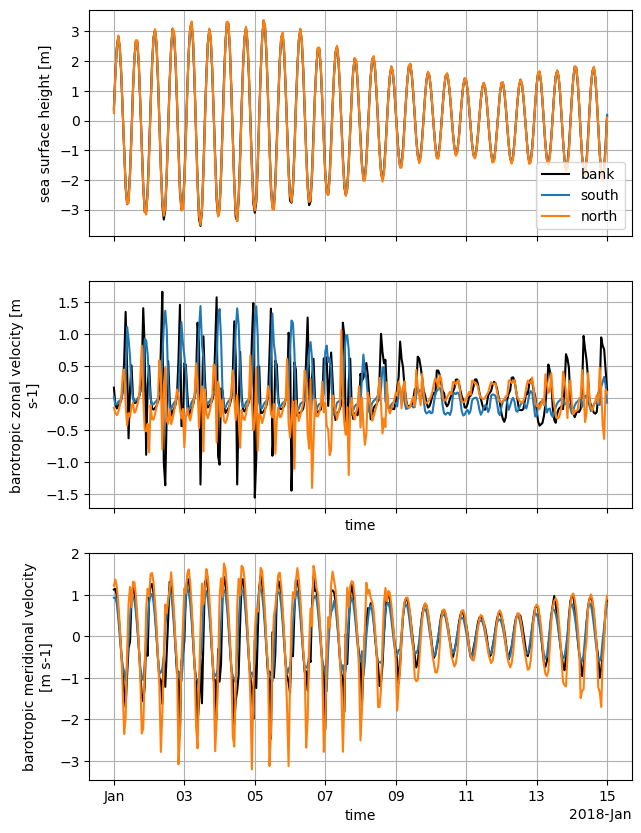

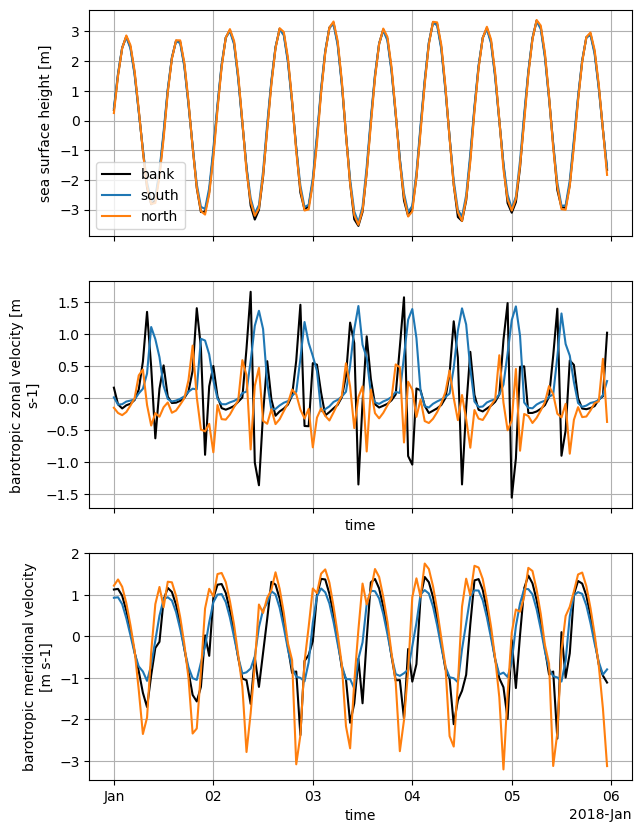

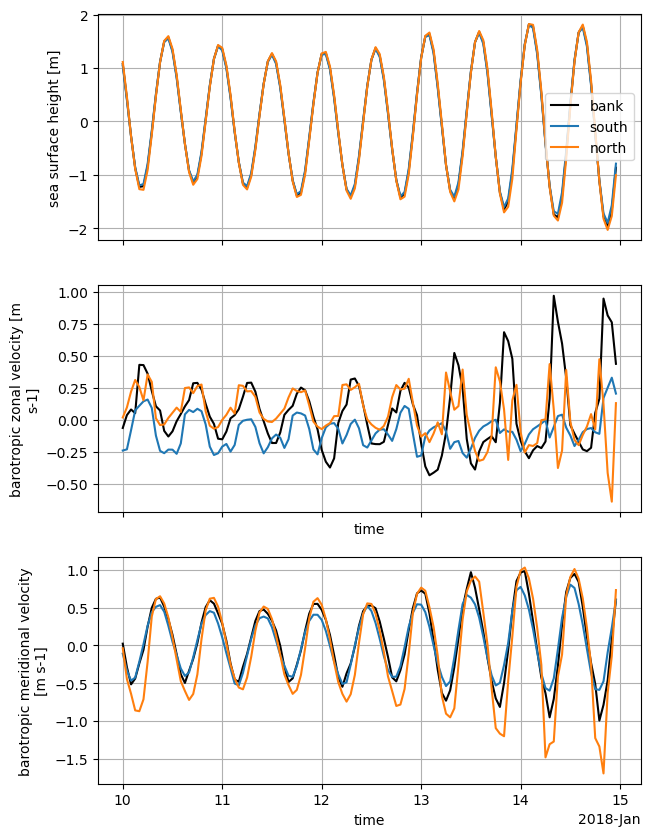

In [21]:
plot_tseries(st)
plot_tseries(st.isel(time=slice(0*24,5*24)))
plot_tseries(st.isel(time=slice(9*24,14*24)))

### maps of sea level

In [55]:
def plot_eta(files, t, suffix, flow=False, **kwargs):

    f = files.loc[t, "files"]
    print(f)
    
    ds = _read_one_file(f)

    da = ds.XE
    da = da - float(st.sel(station="bank", time=t).XE) # center around bank

    if flow:
        if "level" in ds.u.dims:
            u, v = ds.u.isel(level=0, time=0), ds.v.isel(level=0, time=0)
        else:
            u, v = ds.u.isel(time=0), ds.v.isel(time=0)
        if suffix=="3D_250m":
            uv = ((u, v), 4, dict(scale=40), (1.,.8,.87))
        elif suffix=="3D_500m":
            uv = ((u, v), 2, dict(scale=40), (1.,.8,.87))
    else:
        uv = None
    
    fig, ax, cbar = plot_iroise(
        da, 
        #cmap="magma",
        cmap="Spectral_r",
        contours=True,
        uv = uv,
        **mkwargs,
        **kwargs,
    )
    
    # add bathymetric contours
    ds.H0.plot.contour(
        x="longitude", y="latitude",
        levels=np.arange(0,150,20),
        colors="0.5", linewidths=1, alpha=.5,
        ax=ax,transform=ccrs.PlateCarree(),
    )
    
    for s, p in stations.items():
        ax.scatter(p[0], p[1], s=100, c="w", marker="*", transform=ccrs.PlateCarree())
        ax.text(p[0], p[1]-.005, s, size=11, transform=ccrs.PlateCarree(), va="top", ha="center")
    
    ax.set_title(f"sea level {t} - {suffix}")

    # add inset with sea level
    axs = fig.add_axes([.65, .2, .2, .1])
    dt = pd.Timedelta("1D")
    _t = pd.Timestamp(t)
    st.sel(station="bank", time=slice(_t-dt,_t+dt)).XE.plot(ax=axs)
    axs.axvline(_t, color="k")
    axs.set_title("")
    axs.set_xlabel("")
    axs.set_ylabel("")
    for label in axs.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    axs.grid()

/home/ref-oc-public/modeles_marc/l1_v9/MARC_L1-MARS2D-FINIS250/best_estimate/2018/MARC_L1-MARS2D-FINIS250_20180102T0000Z_MeteoMF.nc


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


/home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-FINIS/best_estimate/2018/MARC_F1-MARS3D-FINIS_20180102T0100Z.nc


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "level" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To acces

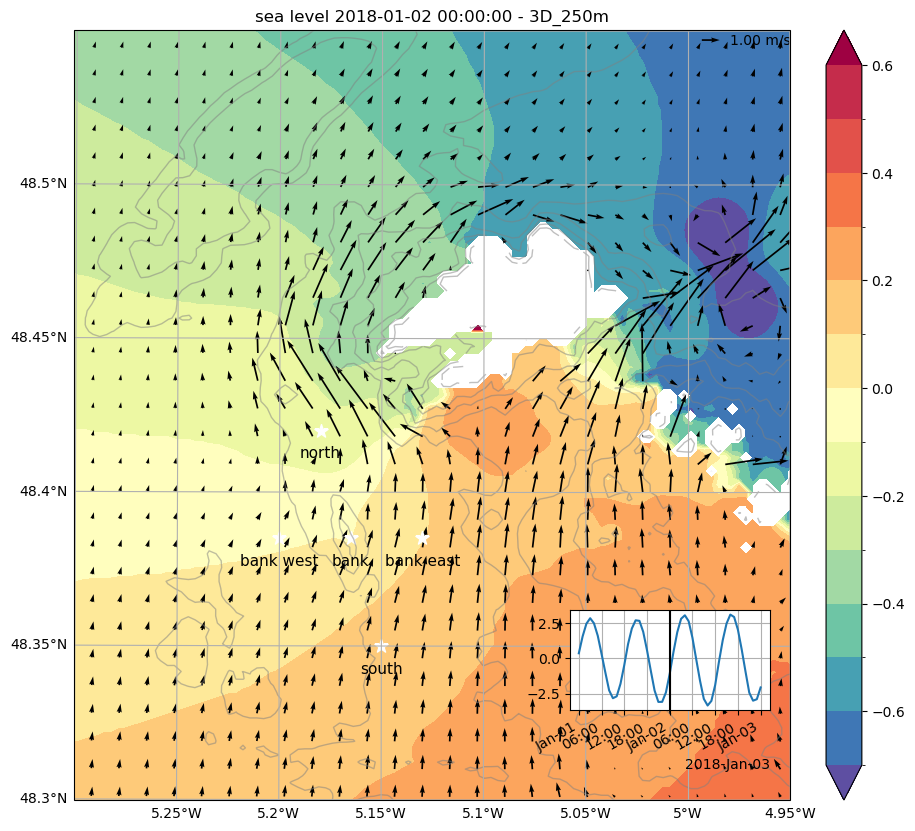

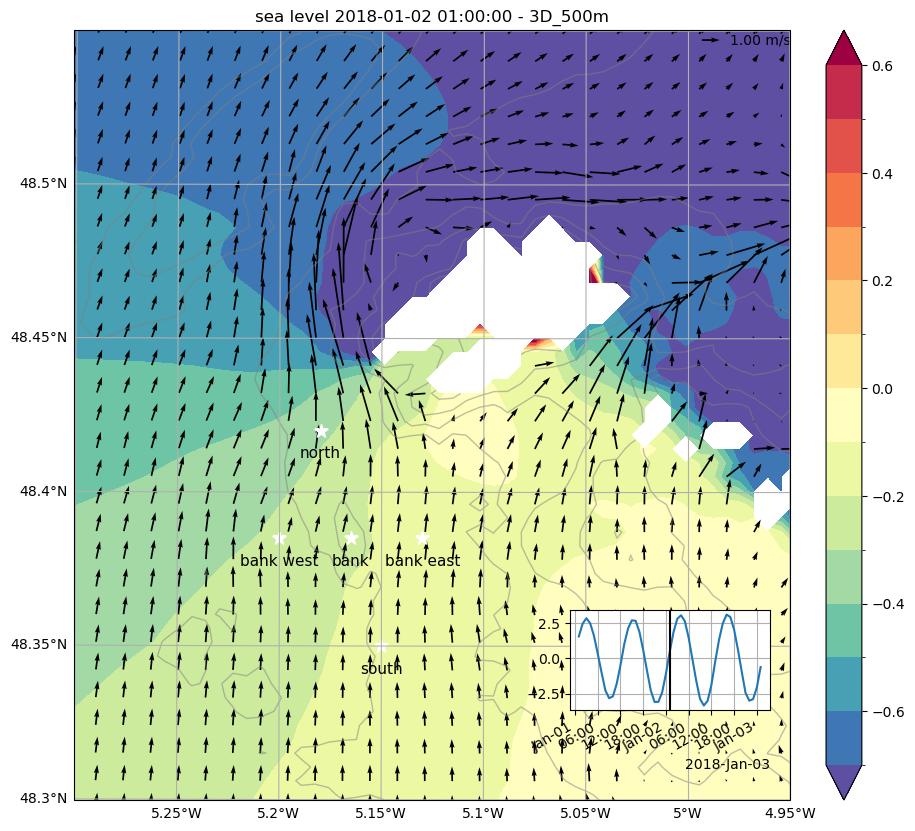

In [56]:
# spring tide - flood

kwargs = dict(
    #vmin=-2., vmax=-.5, levels=20, 
    #levels=np.arange(-2,-.5,.1),
    levels=np.arange(-.7, .7, .1),
)
plot_eta(files_3d_250, "2018-01-02 00:00:00", "3D_250m", flow=True, **kwargs)
plot_eta(files_3d_500, "2018-01-02 01:00:00", "3D_500m", flow=True, **kwargs)

/home/ref-oc-public/modeles_marc/l1_v9/MARC_L1-MARS2D-FINIS250/best_estimate/2018/MARC_L1-MARS2D-FINIS250_20180112T1000Z_MeteoMF.nc


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


/home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-FINIS/best_estimate/2018/MARC_F1-MARS3D-FINIS_20180112T1000Z.nc


/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "level" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To acces

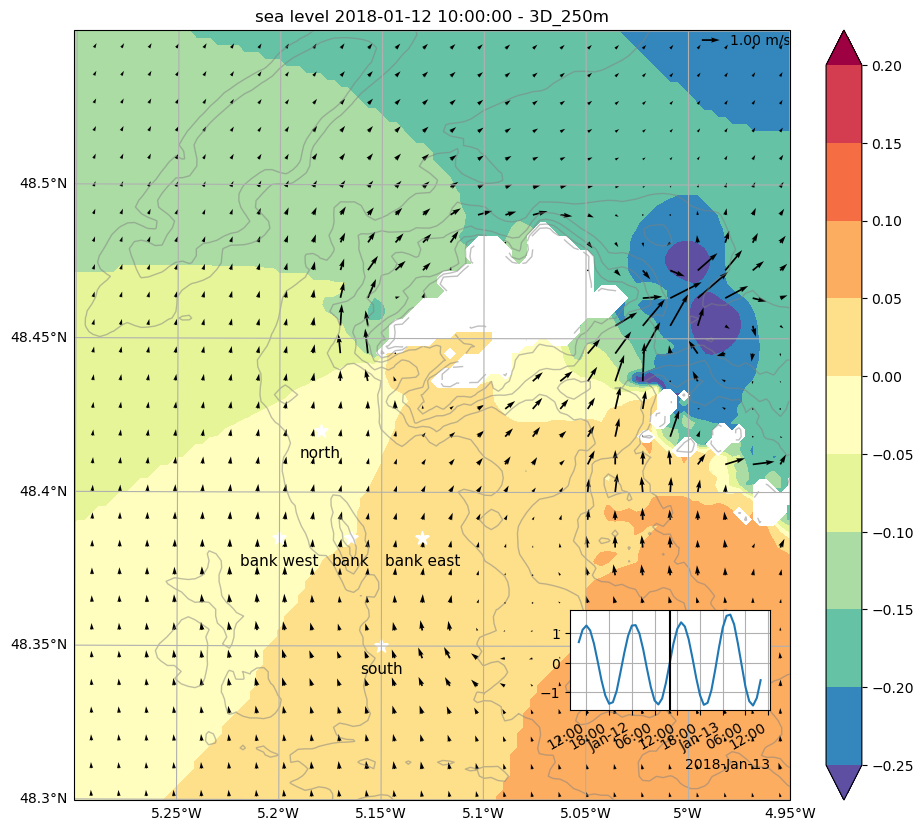

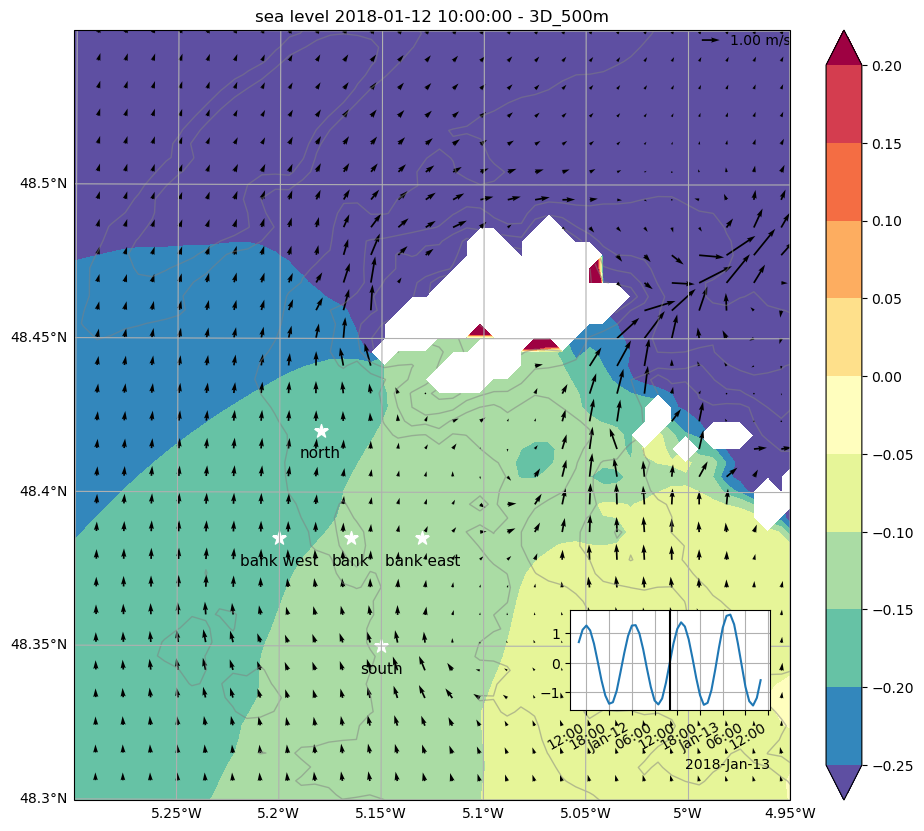

In [57]:
# neap tide - flood
kwargs = dict(
    #vmin=-2., vmax=-.5, levels=20, 
    #vmin=-2., vmax=-.5, levels=20, 
    levels=np.arange(-.25,.25,.05),
)

plot_eta(files_3d_250, "2018-01-12 10:00:00", "3D_250m", flow=True, **kwargs)
plot_eta(files_3d_500, "2018-01-12 10:00:00", "3D_500m", flow=True, **kwargs)

---
## Movies

In [58]:
def plot_print(files, t, s, **kwargs):
    
    f = files.loc[str(t), "files"]
    
    #f = files.loc["2018-01-01":"2018-01-30", "files"].iloc[1]
    #ds = xr.open_dataset(f)
    #xr.open_dataset(f, engine="h5netcdf")
    #xr.open_dataset(f, engine="scipy")
    
    ds = _read_one_file(f)

    if s=="MARC_2d" and zoom=="ouessant":
        uv_args = 1, dict(scale=40), (1., .8, .901)
    elif s=="MARC_3d_500" and zoom=="ouessant":
        uv_args = 1, dict(scale=40), (1., .8, .901)
    elif s=="MARC_3d_250" and zoom=="ouessant":
        uv_args = 2, dict(scale=40), (1., .8, .901)

    #return ds
    dkwargs = dict(
        zoom=zoom, vmin=0, vmax=150, cmap="GnBu_r",
        uv=((ds["u"], ds["v"]), *uv_args),
        figsize=(10,10),
        title=ds.time.dt.strftime("%Y/%m/%d %H:%M").values+f"  {s}",
        offline=True,
        savefig=os.path.join("/home1/scratch/aponte/figs", f"{s}_{zoom}_"+str(t).replace(" ", "_").replace(":","")+".png"),
    )
    dkwargs.update(kwargs)

    fig, ax, cbar = plot_iroise(ds.H0, **dkwargs)

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


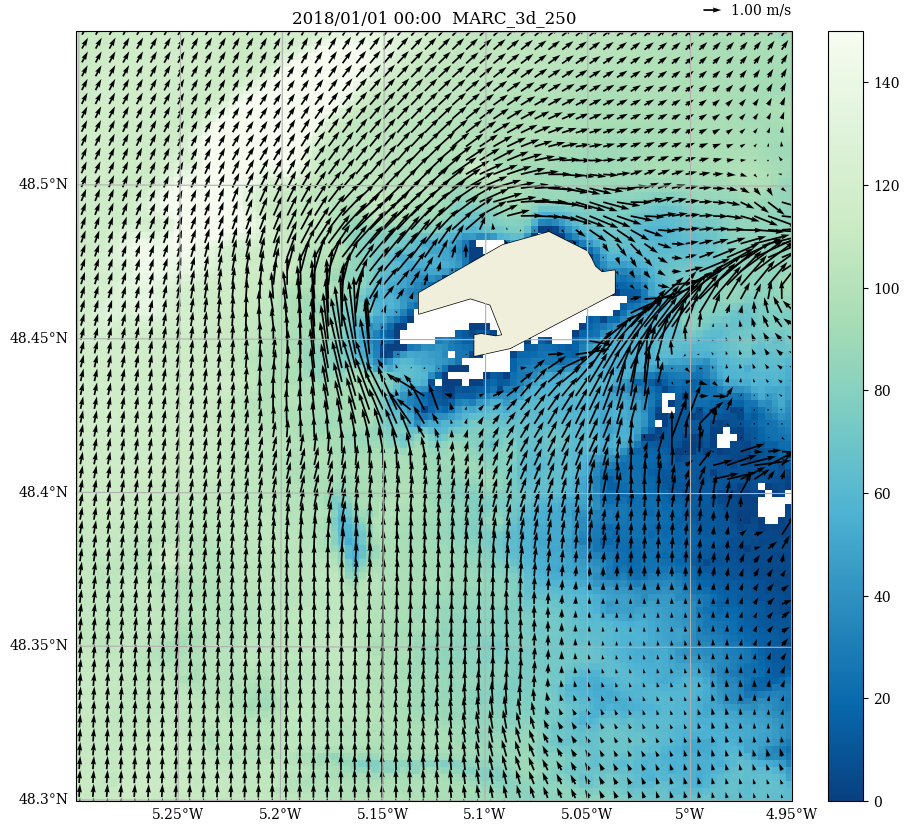

In [59]:
# dev
zoom = "ouessant"
s, files = "MARC_2d", files_2d
s, files = "MARC_3d_500", files_3d_500
s, files = "MARC_3d_250", files_3d_250
t = pd.date_range(start="2018-01-01", end="2018-01-30", freq="1h")[0]

plot_print(files, t, s, zoom=zoom, offline=False, savefig=None)

In [ ]:
zoom = "ouessant"

for s, files in zip(["MARC_2d", "MARC_3d_500", "MARC_3d_250"], [files_2d, files_3d_500, files_3d_250]):
    for t in pd.date_range(start="2018-01-01", end="2018-01-15", freq="1h"):
        plot_print(files, t, s, zoom=zoom)

---

## monochromatic barotropic wave solution

Linearized barotropic Equations of motion assuming a unidirectional monochromatic wave (flat bottom):

$
\begin{align}
(u, v, \eta) &=  \Re \Big\{ (\hat{u}, \hat{v}, \hat{\eta}) e^{i(k x - \omega t)} \Big\},\\
-i \omega u - f v &= -g i k \eta, \\
-i \omega v + f u &= -g i k \eta, \\
-i \omega \eta + ik h u &= 0,
\end{align}
$

Resulting polarization and dispersion relationships:

$
\begin{align}
\hat u &= \frac{\omega}{c^2 k} g\hat\eta , \\
\hat v &= -\frac{i f}{c^2 k} g\hat \eta , \\
\omega^2 &= f^2 + c^2 k ^2, \;\;\mathrm{with}\; c=\sqrt{gh}
\end{align}
$

This for example leads to a solution like:

$
\begin{align}
\eta(x,t) &= \eta_0 \cos(kx - \omega t), \\
u(x,t) &= \frac{\omega}{c^2 k} g \eta_0 \cos(kx - \omega t) , \\
v(x,t) &= \frac{f}{c^2 k} g\hat \eta_0 \sin(kx - \omega t), \\
\end{align}
$


In [187]:
h = 100
omega = 2*2*np.pi/86400
c = np.sqrt(9.81*h)
f = 2*np.cos(np.deg2rad(48.35))*2*np.pi/86400
k = np.sqrt(omega**2-f**2)/c

print(f" h = {h} m, c = {c:.1f} m/s , omega={omega*86400/2/np.pi:.1f} cpd, f={f:.2e}1/s")
print(f" k = {k*1000/2/np.pi:.1e} cpkm, corresponding wavelength: {2*np.pi/k/1000:.0f} km ")

 h = 100 m, c = 31.3 m/s , omega=2.0 cpd, f=9.67e-051/s
 k = 5.5e-04 cpkm, corresponding wavelength: 1811 km 


---

## dev

In [ ]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

#def add_horizontal_metrics(ds, xgrd):

dlong = xgrd.diff(ds.longitude, 'x')   # U
dlonc = xgrd.diff(ds.longitude_u, 'x') # C
dlatg = xgrd.diff(ds.latitude, 'y')    # V
dlatc = xgrd.diff(ds.latitude_v, 'y')  # C

#ds.coords['dxg'], ds.coords['dyg'] = dll_dist(dlong, dlatg, ds.longitude, ds.latitude)
ds.coords['dxc'], ds.coords['dyc'] = dll_dist(dlonc, dlatc, ds.longitude, ds.latitude)

#add_horizontal_metrics(ds, xgrd)